# AnalyzeDream 

Code which facilitates the analysis of our dreaming results. Specifically, we can observe the entirety of the dreaming process for input graphs, keep track of the predicted and actual target properties of the graph as it mutates, and calculate the mean information entropy throughout the layers

Requires the installation of the digitial discovery framework PyTheus, featured here: https://arxiv.org/abs/2210.09980


# Part 1: Dreaming on the Output Layer

For demonstrative purposes, we shall employ our code to analyze 10 dreamed examples for the task of optimizing the W-state fidelity

In [2]:
# Requisite modules to import

from pytheus import help_functions as hf, theseus as th, fancy_classes as fc, graphplot as gp
from neuralnet import load_model
from datagen import generatorGraphFidelity
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import glob

# We load up the csv files which contains information about the dreamed examples

directory = "dreamfiles/output_layer/W_Fidelity"
neuron_indices = [0]
fileLists = []
data = []
for neuron in neuron_indices:
    fileLists.append(glob.glob(f"{directory}/*_{neuron}.csv"))
    
fileLists = fileLists[0]

for filename in fileLists:
    df = pd.read_csv(filename, sep=";", names=['fidelity', 'activation', 'graph'])
    data.append([list(df.iloc[:, 0]), list(df.iloc[:, 1]), list(df.iloc[:,2])])


# Plotting Fidelity-Loss Evolution

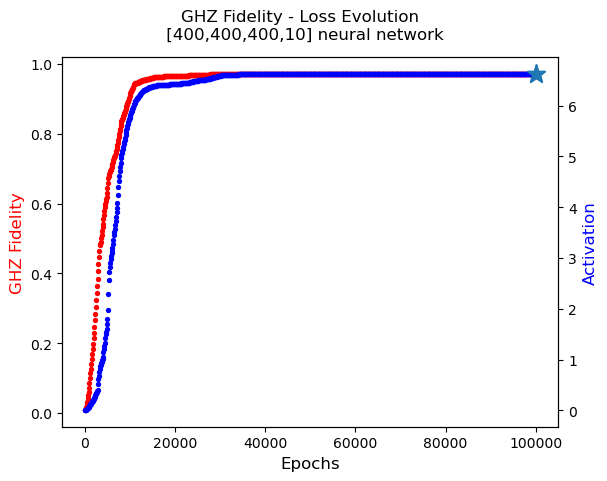

In [3]:
# Here, we load up the initial and final fidelities of the dreamed graphs. 

init = []
final = []

for ii, sample in enumerate(data):
    init.append(sample[0][0])
    final.append(sample[0][-1])
    
    
# We identify the model graph of our sample which possesses the highest dreamed fidelity. 

maxFid = np.argmax(final)
fancySample = data[maxFid]


# We can obtain the total number of epochs from the datalength. 
# We save data every 100 epochs in the procedure, so we therefoe have e.g.
# 100 * len(data[0][0]) epochs

epochs = np.arange(0,len(data[0][0])*100,100)

# create figure and axis objects with subplots()
fig,ax = plt.subplots()

fig.suptitle("GHZ Fidelity - Loss Evolution \n [400,400,400,10] neural network")


# set x-axis label
ax.set_xlabel("Epochs", fontsize = 12)
# set y-axis label
ax.set_ylabel("GHZ Fidelity",
              color="red",
              fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=10)

ax2=ax.twinx()
# set x-axis label
ax2.set_xlabel("Epochs", fontsize = 12)
# set y-axis label
ax2.set_ylabel("Activation",
              color="Blue",
              fontsize=12)


# make a plot for the true fidelity
ax.scatter(epochs,fancySample[0], color='r', s = 8)
ax.plot(epochs[-1],[fancySample[0][-1]], marker='*', markersize=14)

# make a plot for the activation
ax2.scatter(epochs,fancySample[1], color='b', s=8)
ax2.plot(epochs[-1],[fancySample[1][-1]], marker='*', markersize=14)

# Plotting the distribution of initial versus dreamed graph

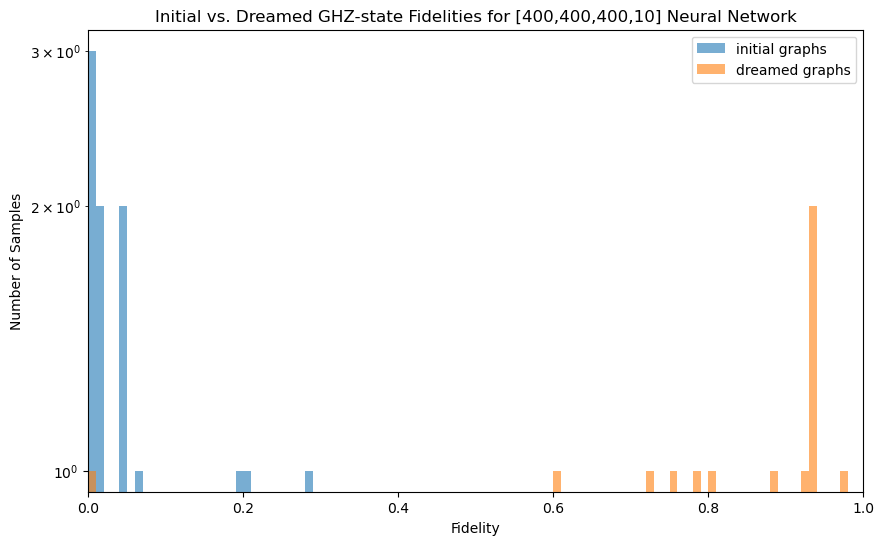

In [12]:
# Make the histogram plot
plt.figure(figsize=(10, 6))
bins = np.arange(0, 1, 0.01)
plt.title('Initial vs. Dreamed W-state Fidelities for [400,400,400,10] Neural Network')
plt.yscale('log')
plt.xlim([0,1])
plt.hist(init, bins=bins, alpha=0.6, orientation="vertical",label='initial graphs')
plt.hist(final, bins=bins, alpha=0.6, orientation="vertical",label='dreamed graphs')
plt.xlabel('Fidelity')
plt.ylabel('Number of Samples')
plt.legend(prop={'size': 10})


# Observing the graphs throughout the dreaming process

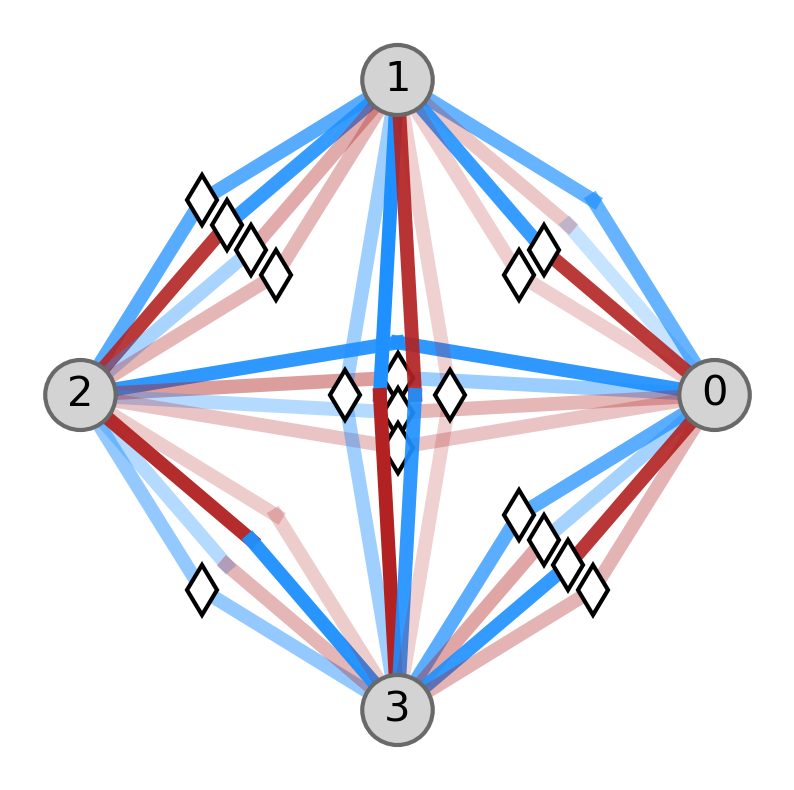

0.971375521756408


In [24]:
# These are parameters which specifies the quantum graph and the particular state on which we compute the fidelity

DIM = [2] * 4 # We are working with quadripartite, two-dimensional quantum graphs
kets = hf.makeState('1000+0100+0010+0001') # This is the W-State
state = fc.State(kets, normalize=True)

# The idea is that we construct a complete graph, then 'paint' over it using the edge weights of the dreamed graph

edges = th.buildAllEdges(DIM)
graph = fc.Graph(edges)

# Load up the edge weights of the model graphs for all epochs. There are ~1000 entries 
# corresponding to every hundreth step of the dreaming process

graphWeights = []

for weights in fancySample[2]:
    temp = eval(weights)
    temp = [w / np.max(np.abs(temp)) for w in temp] # renormalization step
    graphWeights.append(temp)
    
    
# Now we can plot the graph. For a fancier plot, enable 'leiwandplot'

def plotGraph(graphWeight, edges, epoch, threshold, leiwandPlot=False):
    
    # graphWeights - list - list of edge weights per epoch
    # edges - Graph - the complete set of edges for a two-dim, quadripartite graph
    # epoch - int - the epoch (in units of 100s) on which we view the dreaming process
    # threshold - float - number between 0 and 1 which cuts off edges with weights below the threshold
    # leiwandPlot - boolean - this enables fancier graph plots
    
    graph = fc.Graph(edges=edges, weights=graphWeight[epoch])
    graph.purge(threshold=threshold, update=True)
    newgraph = fc.Graph(graph.edges, weights=graph.weights)
    gp.graphPlot(newgraph)
    if (leiwandPlot):
        gp.leiwandPlot(newgraph, name=f"graph_{epoch}")
        
    return newgraph

dreamGraph = plotGraph(graphWeights, edges, 1000 ,0)

# The graph object itself also lets us compute other properties such as its corresponding state 
# and its fidelity with respect to the W-state

dreamGraph.getState()
dreamstate = dreamGraph.state
dreamstate.normalize()
print(np.abs(dreamstate@state)**2)

# Part 2: Dreaming at the Intermediate Layers

For demonstrative purposes, we showcase dreaming results for one input graph for the 16th layer of the $[36^{26}]$ neural network

In [30]:
# As before, let's load up the dreamed files

directories = ["dreamfiles/intermediate_layer/36_25_network_layer16"]
print(directories)

# Specify the neurons that we would like to investigate. For a [36^26], network, we have 36 neurons in all

neuron_indices = np.arange(36)

# Specify the input graph index (we are looking at the 1st one)

start_graph_index = [0]

# We are now ready to load 

fileLists = []
data = []

for directory in directories:
    fileList = []
    for neuron in neuron_indices:
        for start_graph in start_graph_index:
            fileList += glob.glob(f"{directory}/dream{start_graph}_{neuron}.csv")
            
    fileLists.append(fileList)


for fileList in fileLists:
    for filename in fileList:
        df = pd.read_csv(filename, sep=";", names=['fidelity', 'activation', 'graph'])
        data.append([list(df.iloc[:, 0]), list(df.iloc[:, 1]), list(df.iloc[:, 2])])
    
# This eliminates any empty elements    
    
res = [ele for ele in fileLists if ele != []]

['dreamfiles/intermediate_layer/36_25_network_layer16']


We will be dealing with probabilities. It will be of interest to us to normalize these probabilities in a nice way

In [32]:
# We want to normalize the probabilities corresponding to (a) all possible perfect matchings and (b) the 16 possible kets.

def getProbNorm(listOfProbs):
    listOfProbs = np.array(listOfProbs)
    listOfProbs = listOfProbs.flatten()
    probSum = 0
    for prob in listOfProbs:
        probSum += np.abs(prob)**2
    return np.sqrt(1/probSum)

# Computing $p_{16,j}$

These functions facilitate the calculation of the 3 x 16 array of perfect matching probability amplitudes. In practice, we consider our probabilities over a range of different quantum graphs, so we also average out the amplitudes for every possible perfect matching. 

In [36]:
from datagen import constructGraph 
from pytheus.lossfunctions import fidelity
import csv

# Functions are very similar to the regular histogram making ones. Is just that now we're dealing with three of them. 

cnfgfid = {"heralding_out": False, "imaginary": False}
fid = fidelity(graph,state,cnfgfid)

# Loads the initial graphs and saves them as .csv files

def saveInit(fileList):
    weightList = []
    for ii, filename in enumerate(fileList):
        df = pd.read_csv(filename, sep=";", names=['fidelity', 'activation', 'graph'])
        initWeights = eval(df.iloc[0, 2])
        initWeights = [w / np.max(np.abs(initWeights)) for w in initWeights] # renormalization step
        output_fidelity = constructGraph(initWeights, [2]*4, fid, 'a')[0]
        with open(f'init_{ii}.csv', 'a') as f:
                writer = csv.writer(f, delimiter=";")
                writer.writerow([list(initWeights), output_fidelity])
        

def loadAll(fileList):
    weightList = []
    for filename in fileList:
        df = pd.read_csv(filename, sep=";", names=['fidelity', 'activation', 'graph'])
        finalWeights = eval(df.iloc[-1, 2])
        finalWeights = [w / np.max(np.abs(finalWeights)) for w in finalWeights] # renormalization step
        weightList.append(finalWeights)
    
    return weightList


def getPMKets(fileList, edges):
    finalWeights = loadAll(fileList)
    ultiKets = []
    
    # Store all information about the ket amplitudes in seperate lists
    for subList in finalWeights:
        graph = fc.Graph(edges=edges, weights=subList)
        ultiKets.append(getPMAmplitudes(graph))
    return ultiKets


# This retrieves information about the kets and their corresponding values from each graph.  

def extractPMKets(fileList, edges, isProb):
    ultiKets = getPMKets(fileList, edges)
    totalPMKets = {}
    for ket in ultiKets[0].keys():
        ketList = []
        for graph in ultiKets:
            if (isProb):
                ketList.append(np.abs(graph[ket])**2)
            else:
                ketList.append(graph[ket])
        totalPMKets[ket] =  ketList
        
    return totalPMKets


# Adds them up, computes variance, then plots that over histogram 

def getMeanVar(fileList, edges):
    # Obtain total ket dictionary 
    totalKets = extractPMKets(fileList, edges, True)
    # Compute mean/variance for each ket
    meanPMKet = {}
    varPM = []
    for ket in totalKets.keys():
        meanPMKet[ket] = np.mean(totalKets[ket],axis = 0)
        varPM.append(np.var(totalKets[ket],axis =0))
    return meanPMKet, varPM

# This returns the contributions due to perfect matchings for each ket given a graph as input

def getPMAmplitudes(graph):
    states = graph.state_catalog
    kets = list(states.keys())
    ultiKet = {}
    for ket in kets:
        pms = []
        for subgraph in states[ket]:
            pms.append(np.prod([graph[edge] for edge in subgraph]))
        ultiKet[ket] = pms
    return ultiKet


# Compute and normalize perfect matching amplitudes

In [37]:
# Let's compute the perfect matchings for each one of our files

meanPMs = []

for layer in res:
    meanPMs.append(list(getMeanVar(fileList, edges)[0].values()))


# The probabilities are all also normalized such that sum of absolute square equals 1

for ii in range(len(meanPMs)):
    norm = getProbNorm(meanPMs[ii])
    meanPMs[ii] = [[arr * norm] for arr in meanPMs[ii]]
    

Here, we can also compute a 1 x 16 array consisting of just the ket probabilities. Similar deal as perfect matchings, just with less to deal with. 

In [38]:
# This retrieves information about the resulting states from all the dreamed graphs
    
def getKets(fileList, edges):
    finalWeights = loadAll(fileList)
    dreamStates = []
    # Store all information about the ket amplitudes in seperate lists
    for subList in finalWeights:
        graph = fc.Graph(edges=edges, weights=subList)
        graph.getState()
        dreamState = graph.state
        dreamState.normalize()
        dreamStates.append(dreamState.state)
    return dreamStates

# This retrieves information about the kets and their corresponding values from each graph.  

def extractAllKets(fileList, edges, isProb):
    kets = getKets(fileList, edges)
    totalKets = {}
    for ket in kets[0].keys():
        ketList = []
        for k in kets:
            if(isProb):
                ketList.append(np.abs(k[ket])**2)
            else:
                ketList.append(k[ket])
        totalKets[ket] = ketList
    return totalKets

# Adds them up, computes variance, then plots that over histogram 

def getKetMeanVar(fileList, edges):
    # Load up relevant parameters
    isProb = cnfg['isProb']
    saveDirec = cnfg['saveDirec']
    # Obtain total ket dictionary 
    totalKets = extractAllKets(fileList, edges, True)
    # Compute mean/variance for each ket
    meanKet = {}
    var = []
    for ket in totalKets.keys():
        meanKet[ket] = np.mean(totalKets[ket])
        var.append(np.var(totalKets[ket]))
    return meanKet, var

# Now we compute the ket-specific probabilities

meanKets = []
for layer in res:
    meanKets.append(list(getKetMeanVar(layer, edges)[0].values()))

# As before, let us normalize
for ii in range(len(meanKets)):
    norm = getProbNorm(meanKets[ii])
    meanKets[ii] = [ketProb * norm for ketProb in meanKets[ii]]
    

# Make 2D/3D Plot of Histogram

In [163]:
#Let's get ready to plot those histograms

print(meanPMs[-1][0])
sampleMean = getMeanVar([res[-1][0]], edges)[0]

x_ticks = []
for ket in sampleMean.keys():
    x_ticks.append(f"|{ket[0][1]},{ket[1][1]},{ket[2][1]},{ket[3][1]}>")
x_ticks = x_ticks

plt.imshow(meanPMs[5])

[array([0.06015987, 0.13584685, 0.00098729])]


IndexError: list index out of range

In [136]:
# Save the 3 x 16 histogram 

with open("3by16.txt", mode="w") as f:
    for ii, entropy in enumerate(meanPMs):
        f.write(f'Graph {ii}: {entropy} \n')
    f.close()


# Compute the information entropy observed for each neuron. (Maybe make a plot alongside each neuron?) 

We compute two kinds of information entropy: one representing the kets, the other representing the PMs

In [165]:
newMeans = []
newKets = []

for layer in meanPMs:
    newMeans.append(np.array(layer).flatten())

for layer in meanKets:
    newKets.append(np.array(layer).flatten())
    


In [169]:
len(newKets)

1

In [170]:
def compEntropy(probs):
    entro = 0
    for prob in probs:
        entro -= prob*np.log2(prob)
    return entro

pmEntropies = []
ketEntropies  = []

# Compute the total information entropy from every neuron

for ii in range(len(newKets)):
    pmEntropy = compEntropy(newMeans[ii])
    ketEntropy = compEntropy(newKets[ii])
    pmEntropies.append(pmEntropy)
    ketEntropies.append(ketEntropy)
 

In [174]:
pmEntropies, ketEntropies

([6.2407686043680295], [5.113174805296404])

In [401]:
with open("Data.txt", mode="w") as f:
    for ii, entropy in enumerate(entropies):
        f.write(f' Graph {ii} \n  {entropy} \n')
    f.close()

In [275]:
# As a overall metric, calculate the mean information entropy of the layer

# Prepare for plotting

entropies = np.array(entropies)
entropies = entropies[:50]
meanEntro = np.mean(entropies)
entropies = np.reshape(entropies, (7,7))

np.argmax(entropies)

5.431675725895457

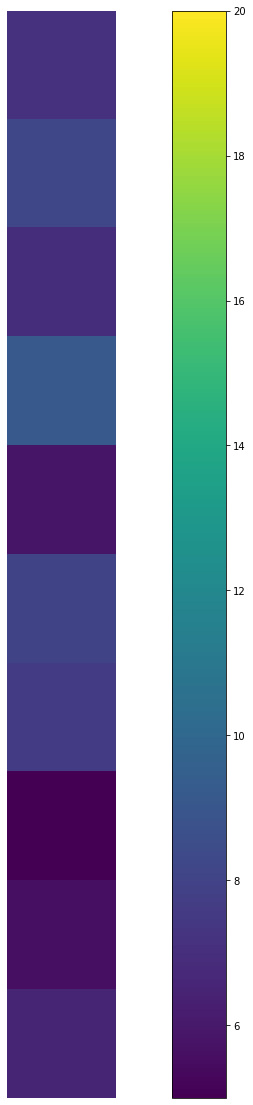

In [409]:
# Make a histogram plot
plt.figure(figsize=(20,20))
plt.imshow(entropies, vmin=5, vmax=20)
plt.axis('off')
plt.colorbar()

In [395]:
res = np.array(res)
res = res.flatten()
res

array(['dreamfiles/dream_ten/dream0_0.csv',
       'dreamfiles/dream_ten/dream1_0.csv',
       'dreamfiles/dream_ten/dream2_0.csv',
       'dreamfiles/dream_ten/dream3_0.csv',
       'dreamfiles/dream_ten/dream4_0.csv',
       'dreamfiles/dream_ten/dream5_0.csv',
       'dreamfiles/dream_ten/dream6_0.csv',
       'dreamfiles/dream_ten/dream7_0.csv',
       'dreamfiles/dream_ten/dream8_0.csv',
       'dreamfiles/dream_ten/dream9_0.csv'], dtype='<U33')

# Make individual plots on the inverse dreamed graphs 

[0.6504940112296481, 0.20020315069205535, -0.29233131268291873, -0.32226540699030315, -0.07397193579810867, 0.09880953051107069, 0.3832116868544065, -0.9816684278331862, 0.6313190627913497, 0.5564707724095707, -0.0227180244402734, 0.783861549258246, 0.7603022344029539, -0.5025684080502197, 0.1733934783762527, 1.0, 0.5175066921647122, -0.003945921900976871, 0.18775202507343555, -0.5646597946324362, -0.052226146648073894, 0.403683331001195, -0.6456831047569724, 0.5909504991580177]
State:
{((0, 0), (1, 0), (2, 0), (3, 0)): -0.06888948420770799,
 ((0, 0), (1, 0), (2, 0), (3, 1)): -0.034401393016711655,
 ((0, 0), (1, 0), (2, 1), (3, 0)): -0.022891147985062896,
 ((0, 0), (1, 0), (2, 1), (3, 1)): 0.290280661074874,
 ((0, 0), (1, 1), (2, 0), (3, 0)): 0.06055050097274067,
 ((0, 0), (1, 1), (2, 0), (3, 1)): -0.11076892791207517,
 ((0, 0), (1, 1), (2, 1), (3, 0)): 0.013800840295161976,
 ((0, 0), (1, 1), (2, 1), (3, 1)): -0.26430437627318315,
 ((0, 1), (1, 0), (2, 0), (3, 0)): 0.04361483115965266,

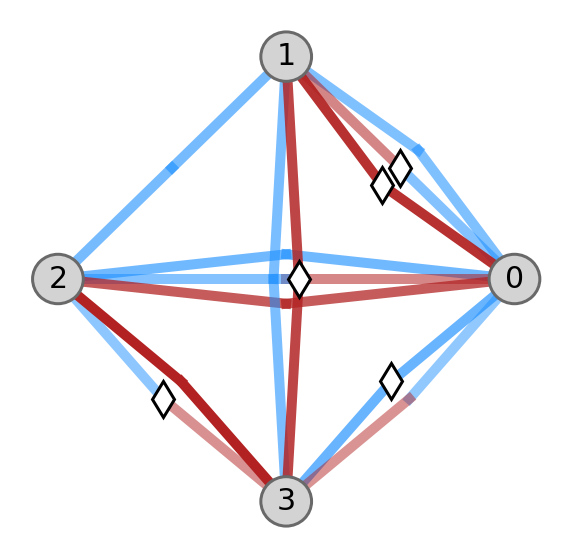

In [408]:
# Plots individual graphs 

def graphPlotter(finalWeights, edges, firstIndex, lastIndex, threshold, fancyPlot=False):
    selectWeights = finalWeights[firstIndex:lastIndex]
    avgWeight = [sum(sub_list) / len(sub_list) for sub_list in zip(*selectWeights)]
    graph = fc.Graph(edges=edges, weights=avgWeight)
    graph.getState()
    dreamstate = graph.state
    dreamstate.normalize()
    print("State:")
    print(graph.state)
    print(f"Fidelity: {(state @ graph.state) ** 2}")
    graph.purge(threshold=threshold, update=True)
    newgraph = fc.Graph(graph.edges, weights=graph.weights)
    if(fancyPlot):
        gp.leiwandPlot(newgraph)
    else:
        gp.graphPlot(newgraph)

        
finalWeights = loadAll(res)
#activations = loadAll(combFile)[0]
print(finalWeights[1])

#maxActive = np.argmax(activations)
graphPlotter(finalWeights, edges,8,9,0.3)   

In [185]:
finalWeights[0]

[0.14498596075757503,
 0.052634283429702,
 0.019207945483042936,
 -0.21758610011054688,
 -0.4027447680987188,
 0.04994124813133548,
 -0.027412096674493153,
 0.08839557948532288,
 0.6790670759750147,
 -0.02373875200523088,
 0.04423018624001642,
 -0.0757639450005822,
 -0.5302692966876964,
 0.004882140056703235,
 -0.010116564809084107,
 -0.14101519723664893,
 -1.0,
 -0.08086768401044628,
 0.021088417882098007,
 0.12865255562093295,
 -0.3164736731583419,
 0.050013484545277716,
 0.017847943979707234,
 -0.24850393493558656]

In [51]:
res

[['dreamfiles/dream_400_one_layer2_888/dream0_0.csv'],
 ['dreamfiles/dream_400_one_layer2_888/dream0_2.csv'],
 ['dreamfiles/dream_400_one_layer2_888/dream0_3.csv'],
 ['dreamfiles/dream_400_one_layer2_888/dream0_4.csv'],
 ['dreamfiles/dream_400_one_layer2_888/dream0_5.csv'],
 ['dreamfiles/dream_400_one_layer2_888/dream0_6.csv'],
 ['dreamfiles/dream_400_one_layer2_888/dream0_7.csv'],
 ['dreamfiles/dream_400_one_layer2_888/dream0_8.csv'],
 ['dreamfiles/dream_400_one_layer2_888/dream0_9.csv'],
 ['dreamfiles/dream_400_one_layer2_888/dream0_10.csv'],
 ['dreamfiles/dream_400_one_layer2_888/dream0_11.csv'],
 ['dreamfiles/dream_400_one_layer2_888/dream0_12.csv'],
 ['dreamfiles/dream_400_one_layer2_888/dream0_13.csv'],
 ['dreamfiles/dream_400_one_layer2_888/dream0_14.csv'],
 ['dreamfiles/dream_400_one_layer2_888/dream0_15.csv'],
 ['dreamfiles/dream_400_one_layer2_888/dream0_16.csv'],
 ['dreamfiles/dream_400_one_layer2_888/dream0_17.csv'],
 ['dreamfiles/dream_400_one_layer2_888/dream0_18.csv'],
 

# Let's make a crazy visualization out of the neural networks (based on this paper)


https://kindxiaoming.github.io/pdfs/BIMT.pdf


![image.png](attachment:image.png)

In [270]:
# Let's create a class for a neuron that holds (a) their designated layer and (b) the weights corresponding to previous neurons

class neuron:
    # x, y - double - coordinates of the neuron along a plane
    # WEIGHTS - array - weights of incoming edges of the neuron 
    # LAYER - int - which layer does the neuron lay in the network?
    # rad - double - how big ought the neurons to appear? 
    def __init__(self, x, y, WEIGHTS, LAYER, RAD):
        self.weights=WEIGHTS
        self.layer=LAYER
        self.x = x
        self.y = y
        self.rad = RAD
    
    def draw(self):
        point = plt.scatter(self.x, self.y,self.layer)
        
    def getWeight(self):
        return self.weights
    
    def getLayer(self):
        return self.layer
    
    def setWeights(self, WEIGHTS):
        self.weights = WEIGHTS
    
    def setLayers(self, LAYER):
        self.layer = LAYER

# Define layer+neuron indices for each layer

hiddenLayers = np.arange(1,4)
neuronsHidden = np.arange(400)
neuronsBN = np.arange(2)
neuRad = 0.05

totalNeurons = [neuronsHidden, neuronsHidden, neuronsBN]

# Now let's create a list of these neurons 

neurons = []

for layer in hiddenLayers:
    neuList = totalNeurons[layer-1]
    for ii, neu in enumerate(neuList):
        x,y = coords[ii]
        weights = model.mynn[layer*2].weight[neu]
        weights = weights.detach().numpy()
        neurons.append(neuron(x, y, weights, layer, neuRad))
        
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

NameError: name 'model' is not defined

In [369]:
meanPMs[0]

[array([0.00302541, 0.05348431, 0.48840927]),
 array([0.10650943, 0.00196674, 0.00216821]),
 array([0.02765483, 0.00027034, 0.00022219]),
 array([1.51302420e-01, 9.94109155e-06, 9.86390637e-07]),
 array([1.07554768e-05, 4.67748433e-02, 3.55294745e-02]),
 array([3.78646395e-04, 1.69341841e-01, 1.57727043e-04]),
 array([9.83143024e-05, 2.36428384e-04, 4.93916977e-02]),
 array([0.00053789, 0.00085596, 0.00021927]),
 array([0.00066106, 0.0068333 , 0.15382737]),
 array([0.0232726 , 0.00025128, 0.22406738]),
 array([6.04265447e-03, 8.27343309e-02, 6.99811830e-05]),
 array([0.03305999, 0.00304233, 0.00010194]),
 array([0.00985762, 0.00597608, 0.01119022]),
 array([0.34703722, 0.02163558, 0.01629985]),
 array([0.09010708, 0.07235552, 0.01555621]),
 array([0.49298516, 0.26195314, 0.02265941])]

In [343]:
res[9]

['dreamfiles/dream_looong_layer18_888/dream0_441.csv',
 'dreamfiles/dream_looong_layer18_888/dream0_442.csv',
 'dreamfiles/dream_looong_layer18_888/dream0_443.csv',
 'dreamfiles/dream_looong_layer18_888/dream0_444.csv',
 'dreamfiles/dream_looong_layer18_888/dream0_445.csv',
 'dreamfiles/dream_looong_layer18_888/dream0_446.csv',
 'dreamfiles/dream_looong_layer18_888/dream0_447.csv',
 'dreamfiles/dream_looong_layer18_888/dream0_448.csv',
 'dreamfiles/dream_looong_layer18_888/dream0_449.csv',
 'dreamfiles/dream_looong_layer18_888/dream0_450.csv',
 'dreamfiles/dream_looong_layer18_888/dream0_451.csv',
 'dreamfiles/dream_looong_layer18_888/dream0_452.csv',
 'dreamfiles/dream_looong_layer18_888/dream0_453.csv',
 'dreamfiles/dream_looong_layer18_888/dream0_454.csv',
 'dreamfiles/dream_looong_layer18_888/dream0_455.csv',
 'dreamfiles/dream_looong_layer18_888/dream0_456.csv',
 'dreamfiles/dream_looong_layer18_888/dream0_457.csv',
 'dreamfiles/dream_looong_layer18_888/dream0_458.csv',
 'dreamfil